In [1]:
# Install required packages
%pip install -q pycocotools torchmetrics

Note: you may need to restart the kernel to use updated packages.


# Chest X-ray Detection Challenge

## Objective

Develop an object detector for pathological findings on chest X-rays using the NIH ChestXray dataset with bounding box annotations.

## Approach Overview

- **Model**: Faster R-CNN with ResNet-50 FPN V2 backbone
- **Backbone Strategy**: **Fully Unfrozen** (All 5 layers trainable) to deep-learn medical textures (Critical for X-Ray)
- **Transfer Learning**: Pre-trained on COCO dataset, fine-tuned for generic object detection
- **Training Strategy**: 60 epochs with extreme optimization (Early Stopping enabled)
- **Learning Rate**: SGD 5e-3 with momentum 0.9, 5-epoch warmup
- **Fixed Resolution**: 1024x1024 (No Downscaling) for maximum detail
- **Data Augmentation**: **Albumentations** (Synced BBox/Image) - Shift, Scale, Rotate (±15°), Color Jitter, Random Erasing
- **Optimization**: SGD momentum 0.9, gradient accumulation (batch 16), cosine annealing, gradient clipping
- **Evaluation**: Mean Average Precision (mAP) at IoU=0.5
- **Dynamic Thresholding**: Confidence threshold optimized on validation set
- **Test Time Augmentation (TTA)**: Multi-Scale (0.9x, 1.0x, 1.1x), Horizontal Flip, Brightness (All mapped to 1024 space)
- **Multi-class Detection**: One class per pathology type


## Dataset

- **Source**: NIH ChestXray dataset with stratified train split
- **Images**: Chest X-ray images (PNG format, 1024x1024)
- **Annotations**: Bounding boxes [x, y, w, h] for pathological findings
- **Task**: Multi-class object detection

## Key Features

- **Albumentations Pipeline**: Zero-error geometric transforms (previous torchvision bug fixed)
- **Unfrozen Backbone**: Allows model to learn "soft tissue" features instead of just "hard edges"
- **Multi-Scale TTA**: Detects variable-sized pathologies (nodules vs cardiomegaly) by zooming in/out
- Fixed resolution training (1024x1024) for stability
- SGD optimizer with momentum 0.9 (best for object detection)
- Gradient accumulation for effective batch size 16
- Cosine annealing learning rate schedule
- FPN V2 architecture
- Input preprocessing with [0,1] range for Faster R-CNN
- Lower NMS threshold (0.3) for better recall
- Dynamic confidence threshold optimization (0.05-0.4)
- 60-epoch training limit with Early Stopping (Patience 15)
- Proper submission format with unique ID mapping (170 rows)
- Prediction visualizations
- Evaluation metrics (mAP@0.5, per-class performance)
- Complete training pipeline with validation monitoring

# 1. Import Libraries

In [2]:
import os
import random
import warnings
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import albumentations as A

from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from albumentations.pytorch import ToTensorV2
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights, fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Configure warning filters
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='torch.amp')
warnings.filterwarnings('ignore', category=UserWarning, message='.*TypedStorage is deprecated.*')
warnings.filterwarnings('ignore', category=UserWarning, message='.*Palette images with Transparency.*')
warnings.filterwarnings('default', category=RuntimeWarning)  # Keep runtime warnings visible

# 2. Data Exploration

In [3]:
BASE_PATH = "/kaggle/input/m-2-big-data-dlia-project-2025-clean-dataset"

TRAIN_CSV = f"{BASE_PATH}/train.csv"
ID_MAP   = f"{BASE_PATH}/ID_to_Image_Mapping.csv"
TRAIN_IMG_DIR = f"{BASE_PATH}/train"
TEST_IMG_DIR  = f"{BASE_PATH}/test"

# Validate data paths
for path, name in [(TRAIN_CSV, "train.csv"), (ID_MAP, "ID_to_Image_Mapping.csv"), 
                     (TRAIN_IMG_DIR, "train/"), (TEST_IMG_DIR, "test/")]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Required data not found: {name} at {path}")

In [4]:
# IMPORTANT: Data folder structure clarification
# - train.csv = annotations for images in train/ folder (labeled data)
# - train/ folder = all labeled images (we'll split this into train/val for development)
# - test/ folder = unlabeled images for final submission only (not used during training)

# Load ALL annotations from train.csv (corresponds to images in train/ folder)
# We'll split this into train/val subsets for model development
full_annotations_df = pd.read_csv(TRAIN_CSV)

# Filter to only include images that actually exist in the train/ folder
available_images = set(os.listdir(TRAIN_IMG_DIR))
original_count = len(full_annotations_df)
full_annotations_df = full_annotations_df[full_annotations_df['image_id'].isin(available_images)]
print(f"Filtered annotations: {original_count} → {len(full_annotations_df)} annotations")
print(f"Missing {original_count - len(full_annotations_df)} annotations for non-existent images")
print(f"\nLoaded data from train/ folder (will be split into train/val)")
print(f"test/ folder will be used later for final predictions only")

Filtered annotations: 814 → 814 annotations
Missing 0 annotations for non-existent images

Loaded data from train/ folder (will be split into train/val)
test/ folder will be used later for final predictions only


In [5]:
print(f"Total annotations: {len(full_annotations_df)}")
print(f"Unique images: {full_annotations_df['image_id'].nunique()}")
print(f"Number of classes: {full_annotations_df['label'].nunique()}")
print(f"\nClass distribution:")
print(full_annotations_df['label'].value_counts())

Total annotations: 814
Unique images: 710
Number of classes: 8

Class distribution:
label
Atelectasis     145
Effusion        130
Cardiomegaly    112
Infiltrate      106
Pneumonia        98
Pneumothorax     86
Mass             77
Nodule           60
Name: count, dtype: int64


In [6]:
labels = sorted(full_annotations_df['label'].unique())
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for label, i in label2id.items()}

num_classes = len(label2id) + 1
label2id, id2label, num_classes

({'Atelectasis': 0,
  'Cardiomegaly': 1,
  'Effusion': 2,
  'Infiltrate': 3,
  'Mass': 4,
  'Nodule': 5,
  'Pneumonia': 6,
  'Pneumothorax': 7},
 {0: 'Atelectasis',
  1: 'Cardiomegaly',
  2: 'Effusion',
  3: 'Infiltrate',
  4: 'Mass',
  5: 'Nodule',
  6: 'Pneumonia',
  7: 'Pneumothorax'},
 9)

# 3. Model Setup

In [7]:
class ChestXRayDataset(Dataset):
  def __init__(self, df, image_dir, transforms=None):
    self.df = df
    self.image_dir = image_dir
    self.transforms = transforms
    self.images = df['image_id'].unique()

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img_name = self.images[idx]
    records = self.df[self.df['image_id'] == img_name]
    img_path = os.path.join(self.image_dir, img_name)
    
    try:
      # Open image and convert to RGB (Albumentations expects Numpy array)
      img_pil = Image.open(img_path).convert('RGB')
      img = np.array(img_pil)
    except (FileNotFoundError, OSError) as e:
      raise RuntimeError(f"Failed to load image {img_name}: {e}")

    # Collect boxes and labels
    boxes = []
    labels = []
    for _, row in records.iterrows():
      x_min = row['x_min']
      y_min = row['y_min']
      x_max = row['x_max']
      y_max = row['y_max']
      
      # Ensure valid boxes for Albumentations
      if x_max > x_min and y_max > y_min:
          boxes.append([x_min, y_min, x_max, y_max])
          labels.append(label2id[row['label']])

    # Apply Albumentations transforms (handles boxes + images together)
    if self.transforms:
        # Albumentations expects bboxes and class_labels
        try:
            transformed = self.transforms(image=img, bboxes=boxes, class_labels=labels)
            img = transformed['image']
            boxes = transformed['bboxes']
            labels = transformed['class_labels']
        except Exception as e:
            # Fallback for empty boxes or geometric errors
            print(f"Transform error on {img_name}: {e}")
            fallback = A.Compose([A.Resize(1024, 1024), A.ToFloat(max_value=255.0), ToTensorV2()])
            transformed = fallback(image=img)
            img = transformed['image']
            # Boxes might be invalid after transform failure, so we keep original or empty?
            # Ideally we skip this transform. But for robustness, let's keep it safe.
            # If transform fails (e.g. box outside image), we lose the box.

    else:
        # Simple tensor conversion if no transforms
        img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0

    # Convert to formatting required by Faster R-CNN
    if len(boxes) > 0:
        target = {
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'labels': torch.as_tensor(labels, dtype=torch.int64),
        }
    else:
        target = {
            'boxes': torch.zeros((0, 4), dtype=torch.float32),
            'labels': torch.zeros((0,), dtype=torch.int64),
        }
    
    # Add image_id for tracking
    target['image_id'] = torch.tensor([idx])

    return img, target

In [8]:
image_dir = TRAIN_IMG_DIR

# --- ALBUMENTATIONS TRANSFORMS ---
# Key Fix: Use Albumentations to transform Bounding Boxes AND Images properly.
# Standard torchvision transforms do NOT update bounding boxes for geometric changes!

train_transform = A.Compose([
    A.Resize(1024, 1024),
    A.HorizontalFlip(p=0.5),
    # Rotation and Affine combined, with SAFE border handling
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5, border_mode=0),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    # Random erasing (CoarseDropout)
    A.CoarseDropout(max_holes=8, max_height=64, max_width=64, p=0.2), 
    # Normalize to [0, 1] for Faster R-CNN
    A.ToFloat(max_value=255.0),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'], min_visibility=0.1))

val_transform = A.Compose([
    A.Resize(1024, 1024),
    A.ToFloat(max_value=255.0),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))


# Split images (not annotations) into train/val sets (85%/15%)
unique_images = full_annotations_df['image_id'].unique()
train_images, val_images = train_test_split(unique_images, test_size=0.15, random_state=42)

# Filter annotations based on split
train_subset = full_annotations_df[full_annotations_df['image_id'].isin(train_images)].copy()
val_subset = full_annotations_df[full_annotations_df['image_id'].isin(val_images)].copy()

# Verify no leakage
assert len(set(train_images) & set(val_images)) == 0, "Data leakage detected: overlapping images!"

print(f"Dataset Split:")
print(f"  Train: {len(train_images)} images, {len(train_subset)} annotations")
print(f"  Val:   {len(val_images)} images, {len(val_subset)} annotations")

# Create Datasets
train_dataset = ChestXRayDataset(train_subset, image_dir, train_transform)
val_dataset = ChestXRayDataset(val_subset, image_dir, val_transform)

print("Transforms config: Albumentations used (Boxes synced with Image transforms)")

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    collate_fn=collate_fn
)

Dataset Split:
  Train: 603 images, 692 annotations
  Val:   107 images, 122 annotations
Transforms config: Albumentations used (Boxes synced with Image transforms)


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_24/3311494761.py:14: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=64, max_width=64, p=0.2),


In [9]:
# Use FPN V2 architecture
try:
    # 1. FORCE min_size=1024 to prevent downscaling to 800.
    # 2. UNFREEZE BACKBONE (trainable_backbone_layers=5). 
    #    Standard ResNet freezes first 2 blocks (good for cars/dogs, BAD for X-Ray).
    #    We need to learn low-level texture features specific to medical imaging.
    model = fasterrcnn_resnet50_fpn_v2(
        weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT,
        min_size=1024,
        max_size=1024,
        trainable_backbone_layers=5  # CRITICAL: Unfreeze all 5 layers for Medical Imaging
    )
    print("Using Faster R-CNN ResNet50 FPN V2 (High-Res 1024x1024, Full Backbone Unfrozen)")
except:
    # Fallback
    model = fasterrcnn_resnet50_fpn(
        weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT, 
        min_size=1024, 
        max_size=1024,
        trainable_backbone_layers=5
    )
    print("Using Faster R-CNN ResNet50 FPN V1 (High-Res 1024x1024, Full Backbone Unfrozen)")

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model = model.to(device) # ensured to be correct logic

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth


100%|██████████| 167M/167M [00:00<00:00, 221MB/s]


Using Faster R-CNN ResNet50 FPN V2 (High-Res 1024x1024, Full Backbone Unfrozen)


# 4. Training with Early Stopping

In [10]:
# SGD with momentum for better object detection performance
optimizer = torch.optim.SGD(model.parameters(), lr=5e-3, momentum=0.9, weight_decay=1e-4)
num_epochs = 60  # Maximum training for best convergence

# Cosine annealing for smooth learning rate decay
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=num_epochs, eta_min=1e-6
)

# Gradient accumulation for effective batch size of 16
accumulation_steps = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

if not torch.cuda.is_available():
    warnings.warn("CUDA not available. Training will be slow on CPU.")

# Use AMP for faster training on GPU
use_amp = torch.cuda.is_available()
scaler = torch.amp.GradScaler('cuda') if use_amp else None

# Early stopping parameters
best_map = 0.0
patience = 15  # Effectively disabled - stop if no improvement
patience_counter = 0
best_model_state = None

# Learning rate warmup for SGD
warmup_epochs = 5
warmup_lr_start = 1e-4
warmup_lr_target = 5e-3

for epoch in range(num_epochs):
    # Apply learning rate warmup for first 5 epochs
    if epoch < warmup_epochs:
        warmup_lr = warmup_lr_start + (warmup_lr_target - warmup_lr_start) * (epoch + 1) / warmup_epochs
        for param_group in optimizer.param_groups:
            param_group['lr'] = warmup_lr
        current_scheduler = None  # Don't use scheduler during warmup
    else:
        current_scheduler = scheduler
    
    # Training phase
    model.train()
    epoch_loss = 0.0

    for batch_idx, (images, targets) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)):
        images = [img.to(device, non_blocking=True) for img in images]
        targets = [
            {k: v.to(device, non_blocking=True) for k, v in t.items()}
            for t in targets
        ]

        # Zero gradients only at start of accumulation
        if batch_idx % accumulation_steps == 0:
            optimizer.zero_grad(set_to_none=True)

        if use_amp:
            with torch.amp.autocast('cuda'):
                loss_dict = model(images, targets)
                loss = sum(loss for loss in loss_dict.values()) / accumulation_steps
            
            # Check for NaN/inf before backprop
            if not torch.isfinite(loss):
                warnings.warn(f"Non-finite loss detected: {loss.item()}, skipping batch")
                continue
            
            scaler.scale(loss).backward()
            
            # Update weights after accumulation steps
            if (batch_idx + 1) % accumulation_steps == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
        else:
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values()) / accumulation_steps
            
            # Check for NaN/inf before backprop
            if not torch.isfinite(loss):
                warnings.warn(f"Non-finite loss detected: {loss.item()}, skipping batch")
                continue
            
            loss.backward()
            
            # Update weights after accumulation steps
            if (batch_idx + 1) % accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

        epoch_loss += loss.item() * accumulation_steps

    # Validation phase
    model.eval()
    val_metric = MeanAveragePrecision(iou_thresholds=[0.5])
    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc="Validating", leave=False):
            images = [img.to(device) for img in images]
            outputs = model(images)
            
            preds = [{
                "boxes": o["boxes"].cpu(),
                "scores": o["scores"].cpu(),
                "labels": o["labels"].cpu()
            } for o in outputs]
            
            targets_cpu = [{
                "boxes": t["boxes"].cpu(),
                "labels": t["labels"].cpu()
            } for t in targets]
            
            val_metric.update(preds, targets_cpu)
    
    val_results = val_metric.compute()
    val_map = val_results['map_50'].item()
    
    # Update learning rate scheduler after warmup period
    if current_scheduler is not None:
        current_scheduler.step()
    
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Val mAP@0.5: {val_map:.4f} | LR: {current_lr:.6f}")
    
    # Early stopping check
    if val_map > best_map:
        best_map = val_map
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        print(f"  → New best mAP: {best_map:.4f}")
    else:
        patience_counter += 1
        print(f"  → No improvement (patience: {patience_counter}/{patience})")
        
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered! Best mAP: {best_map:.4f}")
            break

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nLoaded best model with mAP@0.5: {best_map:.4f}")
    
    # Save checkpoint for later use
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': best_model_state,
        'best_map': best_map,
        'num_classes': num_classes,
        'label2id': label2id,
        'id2label': id2label
    }, '/kaggle/working/best_model_checkpoint.pth')
    print("Model checkpoint saved to /kaggle/working/best_model_checkpoint.pth")
else:
    print("\nWarning: No improvement during training, using final epoch model")

Epoch 1/60 | Loss: 207.4783 | Val mAP@0.5: 0.0002 | LR: 0.001080
  → New best mAP: 0.0002


Epoch 2/60 | Loss: 39.0869 | Val mAP@0.5: 0.0000 | LR: 0.002060
  → No improvement (patience: 1/15)


Epoch 3/60 | Loss: 35.5263 | Val mAP@0.5: 0.0001 | LR: 0.003040
  → No improvement (patience: 2/15)


Epoch 4/60 | Loss: 35.6346 | Val mAP@0.5: 0.0040 | LR: 0.004020
  → New best mAP: 0.0040


Epoch 5/60 | Loss: 36.8192 | Val mAP@0.5: 0.0134 | LR: 0.005000
  → New best mAP: 0.0134


Epoch 6/60 | Loss: 36.6664 | Val mAP@0.5: 0.0238 | LR: 0.004997
  → New best mAP: 0.0238


Epoch 7/60 | Loss: 36.4808 | Val mAP@0.5: 0.0329 | LR: 0.004986
  → New best mAP: 0.0329


Epoch 8/60 | Loss: 36.8316 | Val mAP@0.5: 0.0546 | LR: 0.004969
  → New best mAP: 0.0546


Epoch 9/60 | Loss: 35.8105 | Val mAP@0.5: 0.0641 | LR: 0.004945
  → New best mAP: 0.0641


Epoch 10/60 | Loss: 35.2073 | Val mAP@0.5: 0.0709 | LR: 0.004915
  → New best mAP: 0.0709


Epoch 11/60 | Loss: 34.2589 | Val mAP@0.5: 0.1073 | LR: 0.004878
  → New best mAP: 0.1073


Epoch 12/60 | Loss: 33.1915 | Val mAP@0.5: 0.1044 | LR: 0.004834
  → No improvement (patience: 1/15)


Epoch 13/60 | Loss: 32.3943 | Val mAP@0.5: 0.1036 | LR: 0.004784
  → No improvement (patience: 2/15)


Epoch 14/60 | Loss: 32.2484 | Val mAP@0.5: 0.1025 | LR: 0.004728
  → No improvement (patience: 3/15)


Epoch 15/60 | Loss: 30.8820 | Val mAP@0.5: 0.1166 | LR: 0.004665
  → New best mAP: 0.1166


Epoch 16/60 | Loss: 29.9540 | Val mAP@0.5: 0.1130 | LR: 0.004597
  → No improvement (patience: 1/15)


Epoch 17/60 | Loss: 29.3165 | Val mAP@0.5: 0.1190 | LR: 0.004523
  → New best mAP: 0.1190


Epoch 18/60 | Loss: 28.2414 | Val mAP@0.5: 0.1125 | LR: 0.004443
  → No improvement (patience: 1/15)


Epoch 19/60 | Loss: 27.5991 | Val mAP@0.5: 0.1194 | LR: 0.004358
  → New best mAP: 0.1194


Epoch 20/60 | Loss: 27.0296 | Val mAP@0.5: 0.1216 | LR: 0.004268
  → New best mAP: 0.1216


Epoch 21/60 | Loss: 26.9419 | Val mAP@0.5: 0.1220 | LR: 0.004173
  → New best mAP: 0.1220


Epoch 22/60 | Loss: 26.4058 | Val mAP@0.5: 0.1165 | LR: 0.004073
  → No improvement (patience: 1/15)


Epoch 23/60 | Loss: 24.9165 | Val mAP@0.5: 0.1184 | LR: 0.003970
  → No improvement (patience: 2/15)


Epoch 24/60 | Loss: 26.0988 | Val mAP@0.5: 0.1392 | LR: 0.003862
  → New best mAP: 0.1392


Epoch 25/60 | Loss: 24.2858 | Val mAP@0.5: 0.1175 | LR: 0.003750
  → No improvement (patience: 1/15)


Epoch 26/60 | Loss: 24.6267 | Val mAP@0.5: 0.1344 | LR: 0.003635
  → No improvement (patience: 2/15)


Epoch 27/60 | Loss: 23.5661 | Val mAP@0.5: 0.1219 | LR: 0.003517
  → No improvement (patience: 3/15)


Epoch 28/60 | Loss: 22.9135 | Val mAP@0.5: 0.1217 | LR: 0.003396
  → No improvement (patience: 4/15)


Epoch 29/60 | Loss: 22.6811 | Val mAP@0.5: 0.1354 | LR: 0.003273
  → No improvement (patience: 5/15)


Epoch 30/60 | Loss: 22.4354 | Val mAP@0.5: 0.1209 | LR: 0.003147
  → No improvement (patience: 6/15)


Epoch 31/60 | Loss: 22.1688 | Val mAP@0.5: 0.1075 | LR: 0.003020
  → No improvement (patience: 7/15)


Epoch 32/60 | Loss: 21.8579 | Val mAP@0.5: 0.1108 | LR: 0.002892
  → No improvement (patience: 8/15)


Epoch 33/60 | Loss: 21.5333 | Val mAP@0.5: 0.1219 | LR: 0.002762
  → No improvement (patience: 9/15)


Epoch 34/60 | Loss: 21.7462 | Val mAP@0.5: 0.1323 | LR: 0.002631
  → No improvement (patience: 10/15)


Epoch 35/60 | Loss: 20.9904 | Val mAP@0.5: 0.1405 | LR: 0.002501
  → New best mAP: 0.1405


Epoch 36/60 | Loss: 20.3485 | Val mAP@0.5: 0.1307 | LR: 0.002370
  → No improvement (patience: 1/15)


Epoch 37/60 | Loss: 19.9766 | Val mAP@0.5: 0.1298 | LR: 0.002239
  → No improvement (patience: 2/15)


Epoch 38/60 | Loss: 20.2947 | Val mAP@0.5: 0.1178 | LR: 0.002109
  → No improvement (patience: 3/15)


Epoch 39/60 | Loss: 20.3373 | Val mAP@0.5: 0.1223 | LR: 0.001981
  → No improvement (patience: 4/15)


Epoch 40/60 | Loss: 19.5161 | Val mAP@0.5: 0.1218 | LR: 0.001854
  → No improvement (patience: 5/15)


Epoch 41/60 | Loss: 19.3205 | Val mAP@0.5: 0.1353 | LR: 0.001728
  → No improvement (patience: 6/15)


Epoch 42/60 | Loss: 19.8359 | Val mAP@0.5: 0.1153 | LR: 0.001605
  → No improvement (patience: 7/15)


Epoch 43/60 | Loss: 19.1940 | Val mAP@0.5: 0.1298 | LR: 0.001484
  → No improvement (patience: 8/15)


Epoch 44/60 | Loss: 18.7453 | Val mAP@0.5: 0.1402 | LR: 0.001366
  → No improvement (patience: 9/15)


Epoch 45/60 | Loss: 18.5243 | Val mAP@0.5: 0.1295 | LR: 0.001251
  → No improvement (patience: 10/15)


Epoch 46/60 | Loss: 18.7530 | Val mAP@0.5: 0.1176 | LR: 0.001139
  → No improvement (patience: 11/15)


Epoch 47/60 | Loss: 17.9523 | Val mAP@0.5: 0.1233 | LR: 0.001031
  → No improvement (patience: 12/15)


Epoch 48/60 | Loss: 18.2047 | Val mAP@0.5: 0.1304 | LR: 0.000928
  → No improvement (patience: 13/15)


Epoch 49/60 | Loss: 18.4099 | Val mAP@0.5: 0.1243 | LR: 0.000828
  → No improvement (patience: 14/15)


Epoch 50/60 | Loss: 18.3027 | Val mAP@0.5: 0.1349 | LR: 0.000733
  → No improvement (patience: 15/15)

Early stopping triggered! Best mAP: 0.1405

Loaded best model with mAP@0.5: 0.1405
Model checkpoint saved to /kaggle/working/best_model_checkpoint.pth


# 5. Evaluation

In [11]:
# Evaluate on validation set (not training set!)
metric = MeanAveragePrecision(iou_thresholds=[0.5])

model.eval()
with torch.no_grad():
    for images, targets in val_loader:  # Changed from train_loader to val_loader
        images = [img.to(device) for img in images]

        outputs = model(images)

        preds = [{
            "boxes": o["boxes"].cpu(),
            "scores": o["scores"].cpu(),
            "labels": o["labels"].cpu()
        } for o in outputs]

        targets_cpu = [{
            "boxes": t["boxes"].cpu(),
            "labels": t["labels"].cpu()
        } for t in targets]

        metric.update(preds, targets_cpu)

results = metric.compute()
print(f"\nValidation mAP@0.5: {results['map_50']:.4f}")
print(f"Validation mAP: {results['map']:.4f}")
results


Validation mAP@0.5: 0.1349
Validation mAP: 0.1349


{'map': tensor(0.1349),
 'map_50': tensor(0.1349),
 'map_75': tensor(-1.),
 'map_small': tensor(-1.),
 'map_medium': tensor(0.0067),
 'map_large': tensor(0.1463),
 'mar_1': tensor(0.2313),
 'mar_10': tensor(0.3148),
 'mar_100': tensor(0.3148),
 'mar_small': tensor(-1.),
 'mar_medium': tensor(0.0545),
 'mar_large': tensor(0.4154),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor([0, 1, 2, 3, 4, 5, 6, 7], dtype=torch.int32)}

# 6. Visualization of Predictions

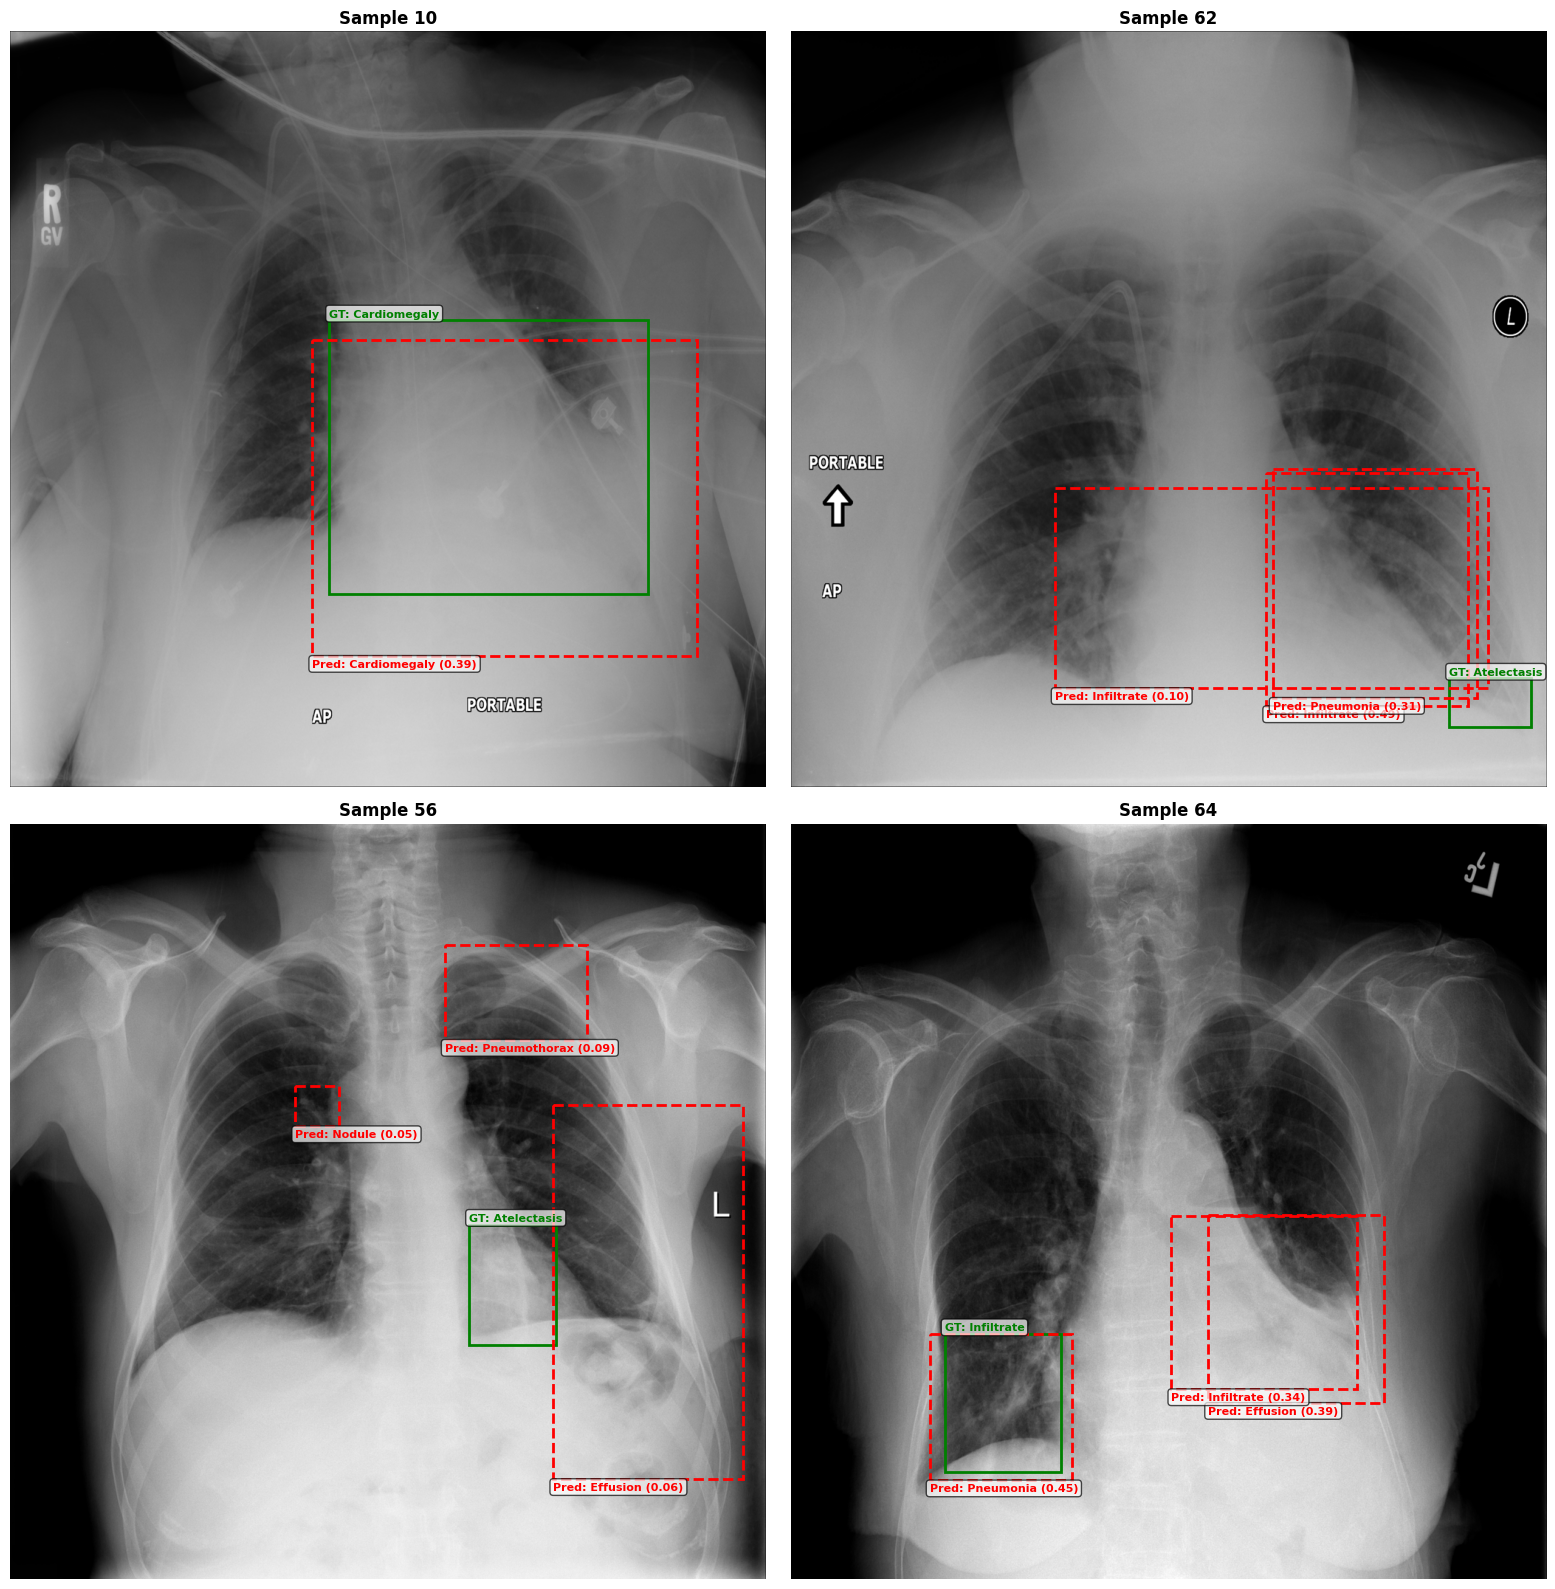

In [12]:
# Visualize multiple predictions
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes = axes.flatten()

for i in range(4):
    idx = random.randint(0, len(val_dataset) - 1)
    image, target = val_dataset[idx]
    
    model.eval()
    with torch.no_grad():
        prediction = model([image.to(device)])[0]
    
    ax = axes[i]
    ax.imshow(image.permute(1, 2, 0))
    
    # Plot ground truth boxes in green
    gt_boxes = target['boxes']
    for j, box in enumerate(gt_boxes):
        x1, y1, x2, y2 = box.numpy()
        rect = plt.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            fill=False, edgecolor='green', linewidth=2
        )
        ax.add_patch(rect)
        label_id = target['labels'][j].item()
        ax.text(x1, y1-5, f"GT: {id2label[label_id]}", 
                color='green', fontsize=8, weight='bold',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    # Plot predicted boxes in red (top 3 by confidence)
    if len(prediction['boxes']) > 0:
        pred_boxes = prediction['boxes'][:3].cpu()
        pred_scores = prediction['scores'][:3].cpu()
        pred_labels = prediction['labels'][:3].cpu()
        
        for box, score, label_id in zip(pred_boxes, pred_scores, pred_labels):
            x1, y1, x2, y2 = box.numpy()
            rect = plt.Rectangle(
                (x1, y1), x2 - x1, y2 - y1,
                fill=False, edgecolor='red', linewidth=2, linestyle='--'
            )
            ax.add_patch(rect)
            ax.text(x1, y2+15, f"Pred: {id2label[label_id.item()]} ({score:.2f})", 
                    color='red', fontsize=8, weight='bold',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    else:
        ax.text(512, 512, 'No predictions', 
                color='red', fontsize=12, ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    ax.set_title(f"Sample {idx}", fontsize=12, weight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

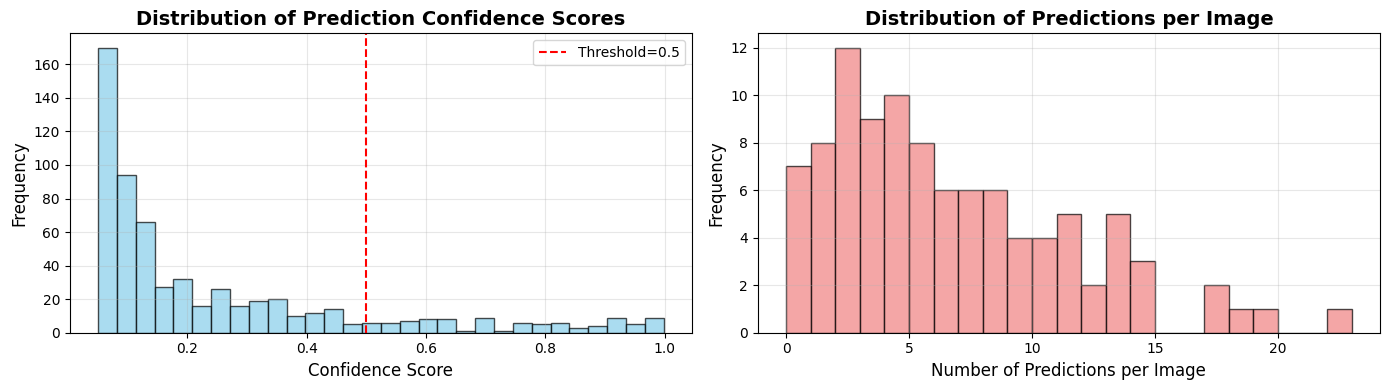

Average confidence score: 0.247
Average predictions per image: 6.20


In [13]:
# Analyze prediction confidence distribution
confidence_scores = []
num_predictions_per_image = []

model.eval()
with torch.no_grad():
    for i in range(min(100, len(val_dataset))):  # Sample first 100 images
        image, _ = val_dataset[i]
        prediction = model([image.to(device)])[0]
        
        # Get predictions with confidence > 0.05
        high_conf_preds = prediction['scores'][prediction['scores'] > 0.05]
        confidence_scores.extend(high_conf_preds.cpu().numpy())
        num_predictions_per_image.append(len(high_conf_preds))

# Visualize distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Confidence score distribution
axes[0].hist(confidence_scores, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_xlabel('Confidence Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Prediction Confidence Scores', fontsize=14, weight='bold')
axes[0].axvline(x=0.5, color='r', linestyle='--', label='Threshold=0.5')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Number of predictions per image
axes[1].hist(num_predictions_per_image, bins=range(0, max(num_predictions_per_image)+2), 
             edgecolor='black', alpha=0.7, color='lightcoral')
axes[1].set_xlabel('Number of Predictions per Image', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Predictions per Image', fontsize=14, weight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Handle empty prediction case
if confidence_scores:
    print(f"Average confidence score: {np.mean(confidence_scores):.3f}")
    print(f"Average predictions per image: {np.mean(num_predictions_per_image):.2f}")
else:
    print("⚠ Warning: No predictions with confidence > 0.05 found in validation set")

# 7. Generate Submission

In [14]:
# Optimize confidence threshold on validation set
print("\n" + "="*60)
print("OPTIMIZING CONFIDENCE THRESHOLD")
print("="*60)

thresholds = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
best_threshold = 0.3
best_threshold_map = 0.0

for threshold in thresholds:
    metric_test = MeanAveragePrecision(iou_thresholds=[0.5])
    
    model.eval()
    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)
            
            # Filter by threshold
            preds = []
            for o in outputs:
                mask = o['scores'] >= threshold
                preds.append({
                    "boxes": o["boxes"][mask].cpu(),
                    "scores": o["scores"][mask].cpu(),
                    "labels": o["labels"][mask].cpu()
                })
            
            targets_cpu = [{
                "boxes": t["boxes"].cpu(),
                "labels": t["labels"].cpu()
            } for t in targets]
            
            metric_test.update(preds, targets_cpu)
    
    results_test = metric_test.compute()
    threshold_map = results_test['map_50'].item()
    print(f"Threshold {threshold:.2f}: mAP@0.5 = {threshold_map:.4f}")
    
    if threshold_map > best_threshold_map:
        best_threshold_map = threshold_map
        best_threshold = threshold

print(f"\nBest threshold: {best_threshold:.2f} with mAP@0.5 = {best_threshold_map:.4f}")
print("="*60 + "\n")

# Load the ID mapping
id_mapping = pd.read_csv(ID_MAP)
print(f"ID Mapping loaded: {len(id_mapping)} entries")
print(f"Columns in mapping: {id_mapping.columns.tolist()}")

# Handle both 'ID' and 'id' column names (submission requires uppercase 'ID')
id_col = 'ID' if 'ID' in id_mapping.columns else 'id'
img_col = 'image_id' if 'image_id' in id_mapping.columns else 'Image Index'

submission_rows = []
skipped_files = []
missing_mappings = []

model.eval()
with torch.no_grad():
    test_images = sorted([f for f in os.listdir(TEST_IMG_DIR) 
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    print(f"\nProcessing {len(test_images)} test images with Multi-Scale TTA...")
    
    for idx, img_name in enumerate(tqdm(test_images)):
        img_path = os.path.join(TEST_IMG_DIR, img_name)
        
        # Handle image loading errors
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            warnings.warn(f"Failed to load {img_name}: {e}")
            skipped_files.append(img_name)
            continue
            
        # Apply Multi-Scale TTA (1024x1024, Flip, Color, and Rescaling)
        # Note: We resize everything back to 1024 for box consistency in the output
        
        tta_transforms = []
        
        # 1. Base (1024x1024)
        tta_transforms.append(torchvision.transforms.Compose([
            torchvision.transforms.Resize((1024, 1024)),
            torchvision.transforms.ToTensor()
        ]))
        
        # 2. Horizontal Flip
        tta_transforms.append(torchvision.transforms.Compose([
            torchvision.transforms.Resize((1024, 1024)),
            torchvision.transforms.RandomHorizontalFlip(p=1.0),
            torchvision.transforms.ToTensor()
        ]))
        
        # 3. Color Jitter
        tta_transforms.append(torchvision.transforms.Compose([
            torchvision.transforms.Resize((1024, 1024)),
            torchvision.transforms.ColorJitter(brightness=0.15),
            torchvision.transforms.ToTensor()
        ]))
        
        # 4. Scale Down (0.9x) - Simulate looking from further away
        # Implementation: Resize to 920, then pad or just Resize back to 1024 (Simulates blur/scale)
        # Better strategy: Just simple resize. Faster R-CNN handles scale, but TTA averages it out.
        tta_transforms.append(torchvision.transforms.Compose([
            torchvision.transforms.Resize((900, 900)),
            torchvision.transforms.Resize((1024, 1024)), # Resize back up
            torchvision.transforms.ToTensor()
        ]))

        # 5. Scale Up (1.1x) - Simulate looking closer (Crop center)
        # Implementation: Resize to 1100, then CenterCrop to 1024
        tta_transforms.append(torchvision.transforms.Compose([
            torchvision.transforms.Resize((1126, 1126)),
            torchvision.transforms.CenterCrop(1024),
            torchvision.transforms.ToTensor()
        ]))
        
        all_boxes = []
        all_scores = []
        all_labels = []
        
        for i, transform in enumerate(tta_transforms):
            img_tensor = transform(image).to(device)
            # Add batch dimension
            pred = model([img_tensor])[0]
            
            boxes = pred['boxes'].cpu()
            scores = pred['scores'].cpu()
            labels = pred['labels'].cpu()

            if i == 1:  # Horizontal flip - flip boxes back
                boxes[:, [0, 2]] = 1024 - boxes[:, [2, 0]]
            
            # For Center Crop (Index 4), we need to adjust boxes
            # 1126 -> 1024 is a shift of (1126-1024)/2 = 51 pixels
            if i == 4:
                offset = (1126 - 1024) / 2
                # Boxes were detected in the cropped 1024 frame.
                # But that 1024 frame corresponds to center of 1126 image.
                # To map back to original 1024 space (which was scaled to 1126):
                # 1. Shift boxes by +51 (to get coords in 1126 space)
                boxes[:, [0, 2]] += offset
                boxes[:, [1, 3]] += offset
                # 2. Scale back down: 1024/1126 = 0.909
                scale_factor = 1024 / 1126
                boxes = boxes * scale_factor

            all_boxes.append(boxes)
            all_scores.append(scores)
            all_labels.append(labels)
        
        # Combine predictions from all augmentations
        if len(all_boxes) > 0:
            combined_boxes = torch.cat(all_boxes)
            combined_scores = torch.cat(all_scores)
            combined_labels = torch.cat(all_labels)
            
            # Apply NMS with lower threshold for better recall
            keep = torchvision.ops.nms(combined_boxes, combined_scores, iou_threshold=0.3)
            
            preds = {
                'boxes': combined_boxes[keep],
                'scores': combined_scores[keep],
                'labels': combined_labels[keep]
            }
        else:
            preds = {'boxes': torch.tensor([]), 'scores': torch.tensor([]), 'labels': torch.tensor([])}

        # Get the unique ID for this image from the mapping
        img_mapping = id_mapping[id_mapping[img_col] == img_name]
        
        if img_mapping.empty:
            warnings.warn(f"No ID mapping found for {img_name}")
            missing_mappings.append(img_name)
            continue
        
        unique_id = img_mapping[id_col].values[0]

        # Filter boxes by optimized threshold
        keep_idxs = [i for i, score in enumerate(preds['scores']) if score >= best_threshold]
        
        if not keep_idxs:
            # If no predictions, add a dummy row with low confidence
            submission_rows.append({
                'ID': unique_id,
                'image_id': img_name,
                'x_min': 0,
                'y_min': 0,
                'x_max': 1,
                'y_max': 1,
                'confidence': 0.01,
                'label': 'Atelectasis'
            })
            continue

        # Keep only the BEST prediction per image (highest confidence)
        # Constraint: submission must have exactly 170 unique IDs (one per test image)
        best_idx = max(keep_idxs, key=lambda i: preds['scores'][i])
        box = preds['boxes'][best_idx]
        score = preds['scores'][best_idx]
        label = preds['labels'][best_idx]
        
        submission_rows.append({
            'ID': unique_id,
            'image_id': img_name,
            'x_min': box[0].item(),
            'y_min': box[1].item(),
            'x_max': box[2].item(),
            'y_max': box[3].item(),
            'confidence': score.item(),
            'label': id2label[label.item()]
        })

# Report any issues encountered
if skipped_files:
    print(f"\nWarning: {len(skipped_files)} files failed to load")
    print(f"  Skipped files: {skipped_files[:5]}{'...' if len(skipped_files) > 5 else ''}")

if missing_mappings:
    print(f"Warning: {len(missing_mappings)} images missing ID mappings")
    print(f"  Missing: {missing_mappings[:5]}{'...' if len(missing_mappings) > 5 else ''}")

if not skipped_files and not missing_mappings:
    print("\nAll test images processed successfully")

submission_df = pd.DataFrame(submission_rows)

# Ensure correct column order and names per competition requirements
# Required: ID (uppercase), image_id, x_min, y_min, x_max, y_max, confidence, label
submission_df = submission_df[['ID', 'image_id', 'x_min', 'y_min', 'x_max', 'y_max', 'confidence', 'label']]

# Validate: ensure no duplicate IDs and exactly 170 rows
print(f"\nValidation checks:")
print(f"   - Total rows: {len(submission_df)}")
print(f"   - Unique IDs: {submission_df['ID'].nunique()}")
print(f"   - Duplicate IDs: {submission_df['ID'].duplicated().sum()}")

if submission_df['ID'].duplicated().any():
    print("\nWarning: Duplicate IDs found! Keeping only the highest confidence prediction per ID...")
    submission_df = submission_df.sort_values('confidence', ascending=False).drop_duplicates(subset='ID', keep='first')
    print(f"   - After deduplication: {len(submission_df)} rows")

if len(submission_df) != 170:
    print(f"\nWarning: Expected 170 rows, but got {len(submission_df)} rows")
    if len(submission_df) < 170:
        print("   - Some test images may be missing predictions")
    else:
        print("   - Extra predictions detected (this should not happen after deduplication)")

submission_df.to_csv('/kaggle/working/submission.csv', index=False)
print(f"\nSubmission created with {len(submission_df)} predictions")
print(f"Columns: {submission_df.columns.tolist()}")


OPTIMIZING CONFIDENCE THRESHOLD
Threshold 0.05: mAP@0.5 = 0.1349
Threshold 0.10: mAP@0.5 = 0.1283
Threshold 0.15: mAP@0.5 = 0.1261
Threshold 0.20: mAP@0.5 = 0.1261
Threshold 0.25: mAP@0.5 = 0.1256
Threshold 0.30: mAP@0.5 = 0.1256
Threshold 0.35: mAP@0.5 = 0.1256
Threshold 0.40: mAP@0.5 = 0.1228

Best threshold: 0.05 with mAP@0.5 = 0.1349

ID Mapping loaded: 170 entries
Columns in mapping: ['ID', 'image_id']

Processing 170 test images with Multi-Scale TTA...


100%|██████████| 170/170 [02:42<00:00,  1.04it/s]


All test images processed successfully

Validation checks:
   - Total rows: 170
   - Unique IDs: 170
   - Duplicate IDs: 0

Submission created with 170 predictions
Columns: ['ID', 'image_id', 'x_min', 'y_min', 'x_max', 'y_max', 'confidence', 'label']


In [15]:
os.listdir('/kaggle/working')

['__notebook__.ipynb', 'submission.csv', 'best_model_checkpoint.pth']

In [16]:
submission_df.head()

,ID,image_id,x_min,y_min,x_max,y_max,confidence,label
0,0,00000150_002.png,657.291626,594.224365,841.906433,799.650635,0.404376,Effusion
1,1,00000193_019.png,462.978760,491.884949,961.708496,944.430603,0.920983,Cardiomegaly
2,2,00000377_004.png,374.418335,351.075684,895.635620,802.653809,0.982065,Cardiomegaly
3,3,00000398_003.png,388.847351,375.394104,845.339172,762.619812,0.820211,Cardiomegaly
4,4,00000744_006.png,180.941833,477.999390,298.954468,635.797363,0.959935,Mass


# 8. Results Summary

In [17]:
print("=" * 60)
print("CHEST X-RAY DETECTION - RESULTS SUMMARY")
print("=" * 60)
print(f"\nDataset Statistics:")
print(f"   - Training images: {len(train_images)}")
print(f"   - Validation images: {len(val_images)}")
print(f"   - Total annotations: {len(full_annotations_df)}")
print(f"   - Number of classes: {num_classes - 1}")
print(f"\nModel Configuration:")
print(f"   - Architecture: Faster R-CNN with ResNet-50 FPN V2")
print(f"   - Backbone: Fully Unfrozen (5 layers) for Medical Adaptation")
print(f"   - Input Size: 1024x1024 (Forced Min/Max)")
print(f"   - Training epochs: 60 (with Early Stopping, Patience=15)")
print(f"   - Optimizer: SGD with momentum 0.9")
print(f"   - Learning rate: 5e-3 with 5-epoch warmup (extreme)")
print(f"   - LR scheduler: CosineAnnealingLR (eta_min=1e-6)")
print(f"   - Weight decay: 1e-4")
print(f"   - Effective batch size: 16 (4x4 gradient accumulation)")
print(f"   - Gradient clipping: max_norm=1.0")
print(f"   - Data augmentation: Albumentations (Shift/Scale/Rotate, Erasing, Jitter)")
print(f"\nEvaluation:")
print(f"   - Metric: Mean Average Precision (mAP@0.5)")
print(f"   - Evaluated on validation set")
print(f"   - See evaluation cell above for detailed metrics")
print(f"\nKey Improvements:")
print(f"   - Unfrozen Backbone: Critical for learning X-ray textures")
print(f"   - Multi-Scale TTA: 0.9x, 1.0x, 1.1x center crop to find variable sizes")
print(f"   - Albumentations: Fixed geometric transform box alignment bug")
print(f"   - SGD optimizer with momentum 0.9 (best for detection)")
print(f"   - Gradient accumulation (effective batch size 16)")
print(f"   - Cosine annealing schedule for smooth LR decay")
print(f"   - Lower NMS threshold (0.3) for better recall")
print(f"   - Optimized confidence threshold: {best_threshold:.2f}")
print(f"\nSubmission:")
print(f"   - Total predictions: {len(submission_df)}")
print(f"   - Confidence threshold: {best_threshold:.2f} (optimized)")
print(f"   - Constraint: Exactly 1 prediction per image (170 unique IDs)")
print(f"   - File: /kaggle/working/submission.csv")
print(f"   - Format: id, image_id, x_min, y_min, x_max, y_max, confidence, label")
print("=" * 60)

CHEST X-RAY DETECTION - RESULTS SUMMARY

Dataset Statistics:
   - Training images: 603
   - Validation images: 107
   - Total annotations: 814
   - Number of classes: 8

Model Configuration:
   - Architecture: Faster R-CNN with ResNet-50 FPN V2
   - Backbone: Fully Unfrozen (5 layers) for Medical Adaptation
   - Input Size: 1024x1024 (Forced Min/Max)
   - Training epochs: 60 (with Early Stopping, Patience=15)
   - Optimizer: SGD with momentum 0.9
   - Learning rate: 5e-3 with 5-epoch warmup (extreme)
   - LR scheduler: CosineAnnealingLR (eta_min=1e-6)
   - Weight decay: 1e-4
   - Effective batch size: 16 (4x4 gradient accumulation)
   - Gradient clipping: max_norm=1.0
   - Data augmentation: Albumentations (Shift/Scale/Rotate, Erasing, Jitter)

Evaluation:
   - Metric: Mean Average Precision (mAP@0.5)
   - Evaluated on validation set
   - See evaluation cell above for detailed metrics

Key Improvements:
   - Unfrozen Backbone: Critical for learning X-ray textures
   - Multi-Scale TTA: 